# CIEQ6232 Public Transport Demand and Network Planning and Operations

### Pre-requisites

In [1]:
%%capture
%run utils.py # Load auxiliary functions

In [2]:
# Show maps inline
from bokeh.resources import INLINE
import bokeh.io
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from math import sin, cos, sqrt, atan2, radians
bokeh.io.output_notebook(INLINE)
pd.set_option('display.max_columns', None)

Loading BokehJS ...

----

In [3]:
path_to_sqlite="amsterdam.sqlite" # Path where the sqlite database is stored

In [4]:
g=load_gtfs(path_to_sqlite)

In [5]:
path_to_sqlite="amsterdam.sqlite" # Path where the sqlite database is stored
L_space_path="amsterdam.pkl" # Path where the clean L-space graph was stored

In [6]:
g=load_gtfs(path_to_sqlite)

#Get available modes for the city
[mode_to_string(x) for x in g.get_modes()]

['Subway']

### Load L-space graph

In [7]:
L_graph=load_graph(L_space_path)

### Create P-space 

In [8]:
P=P_space(g,
          L_graph,
          start_hour=5, # Same as when building L-space
          end_hour=24, # Same as when building L-space
          mode="Subway") # Same as when building L-space
P = P.to_undirected()
plot_graph(P,"P")

Using headsign field as indicator for the direction of routes


In [9]:
L_graph = L_graph.to_undirected()

# ------------------------------------------  Assignment 2 -------------------------------------------

## Step 1: Create an origin-destination matrix

In [10]:
# Calculate amount of trips between 8-9 AM
residents            = 926560
frac_of_trips_8_9_AM = 0.1
trips_per_resident   = 0.8
Q = frac_of_trips_8_9_AM * trips_per_resident * residents

# Calculate closeness
node_list = []
name_list = []
closeness_list = []
closeness_share = []
total_prod_att = []

# Calculate closeness centrality for each node in the L_graph
for i in L_graph.nodes():
    closeness_list.append(nx.closeness_centrality(L_graph)[i])
    name_list.append(L_graph.nodes.data('name')[i])
    node_list.append(i)

# Calculate share of closeness and total production/attraction
for i in L_graph.nodes():
    closeness_share.append(closeness_list[i] / sum(closeness_list))
    total_prod_att.append(Q * closeness_share[i]) 

# Set-up dataframe
OD_df = pd.DataFrame(list(zip(node_list, name_list, closeness_list, closeness_share, total_prod_att)),
               columns =['node', 'name', 'closeness', 'closeness_share', 'total_prod_att'])
OD_df.set_index(['node'], inplace=True)
#OD_df.sort_values(by=['total_prod_att'], ascending=False)

In [11]:
# Set up space for GTC values
existing_nodes = set(node_list)
for node in existing_nodes:
    OD_df[node] = np.nan

### Calculate GTC values ###

alpha = 2       # 2 times multiplier for waiting time
betas = [5,15]  # 5 minutes for the first transfer, 15 minutes for any transfer after that.
m = 1           # Number of shortest paths to retrieve
gtc = get_all_GTC(L_graph, P, m, alpha, betas)
    
# Fill in GTC values
alfa = 5    # impedance function variable
beta = 0.5  # impedance function variable

# Calculate impendance function and OD passenger flow, assign it to dataframe
f = np.zeros((len(OD_df), len(OD_df[0])))
x = np.zeros((len(OD_df), len(OD_df[0])))
q = a = OD_df['total_prod_att']
for i in range(len(OD_df)):
    for j in range(len(OD_df[0])):
        if i != j:
            my_list = gtc[i][j]
            f[i][j] = alfa * np.exp(-beta * my_list[0]['GTC'])
            x[i][j] = (a[j] * f[i][j] * q[i]) / np.sum(np.delete(a * f[i][j], i))
            OD_df.at[i, j] = x[i][j]

OD_df.drop(['name', 'total_prod_att', 'closeness', 'closeness_share'], axis=1, inplace=True)  # Drop unnecessary columns
OD_df.fillna(0, inplace=True)



0/39
10/39
20/39
30/39
All GTC computed!


In [12]:
def check_OD_matrix(OD_df, Q):
    # Define a tolerance
    tolerance = 1
    # Calculate the total of the OD matrix
    total_OD_matrix = np.sum(OD_df.values)
    #print(f"Total of the OD matrix: {total_OD_matrix}", f"Q: {Q}")
    # Check if the total of the OD matrix is equal to Q within the specified tolerance
    if np.abs(total_OD_matrix - Q) < tolerance:
        print("The total of the OD matrix is equal to Q within the specified tolerance")
    else:
        print("The total of the OD matrix is not equal to Q within the specified tolerance")

    #OD_df.style.format("{:.0f}")
pass

In [13]:
check_OD_matrix(OD_df, Q)

The total of the OD matrix is equal to Q within the specified tolerance


## Step 2: Passenger assignment

In [14]:
beta_I = -0.100   # In-vehicle time
beta_W = -0.162   # Waiting time
beta_T = -0.847   # Number of transfers

alpha = beta_W / beta_I  # Waiting time in relation to the in-vehicle time
betas = [beta_T / beta_I, beta_T / beta_I]  # Transfer time in relation to the in-vehicle time
print(f"alpha: {alpha}, betas: {betas}")
# Number of shortest paths to retrieve
m = 3

gtc = get_all_GTC(L_graph, P, m, alpha, betas)

alpha: 1.6199999999999999, betas: [8.469999999999999, 8.469999999999999]
0/39
10/39
20/39
30/39
All GTC computed!


## Directed graph

In [15]:
L_graph_edges = list(L_graph.edges())

# Create an empty dictionary to store the lists
edge_lists = {edge: [] for edge in L_graph_edges}

# Include the reversed counterparts in edge_lists
for edge in L_graph_edges:
    reversed_edge = tuple(reversed(edge))
    edge_lists[reversed_edge] = []
    
for r in list(L_graph.nodes()):
    for s in list(L_graph.nodes()):
        if r != s:
            origin = r
            destination = s
            
            util = np.zeros(len(gtc[r][s]))
            exp = np.zeros(len(gtc[r][s]))
            prob = np.zeros(len(gtc[r][s]))

            for k in range(len(gtc[r][s])):
                util[k] = gtc[r][s][k]['in_vehicle'] * beta_I + gtc[r][s][k]['waiting_time'] * beta_W + gtc[r][s][k]['n_transfers'] * beta_T
                exp[k] = np.exp(util[k])

            for k in range(len(gtc[r][s])):
                prob[k] = exp[k] / np.sum(exp)
                for m in range(len(gtc[r][s][k]['path'])-1):
                    key = (gtc[r][s][k]['path'][m], gtc[r][s][k]['path'][m+1])
                    edge_lists[key].append(prob[k] *OD_df[r][s])
                    
for key in edge_lists:
    values = edge_lists[key]
    sum_values = sum(values)
    edge_lists[key] = sum_values

In [16]:
edge_lists

{(0, 1): 1137.345453355236,
 (1, 2): 2335.1008733588596,
 (2, 3): 3594.393344184197,
 (3, 4): 4915.0904455198015,
 (4, 5): 6295.1842439226975,
 (5, 6): 7729.944011717811,
 (6, 7): 9210.767351821409,
 (7, 8): 10723.651302720235,
 (8, 9): 12247.210121655173,
 (9, 10): 15482.589202888657,
 (9, 19): 5944.2396409624625,
 (10, 11): 16221.31423686613,
 (11, 12): 9273.586970877057,
 (11, 25): 9324.476510621453,
 (12, 13): 11850.223351949075,
 (12, 25): 9025.631195572425,
 (13, 14): 10594.20708936449,
 (14, 15): 9357.990564491825,
 (15, 16): 8143.929196843455,
 (16, 17): 6954.317906889313,
 (17, 18): 5714.883245726987,
 (18, 23): 2957.2870148472043,
 (18, 22): 2401.356480253068,
 (19, 20): 4672.0465893377805,
 (20, 21): 3516.545504362269,
 (21, 22): 2436.729861627821,
 (23, 24): 1428.390435048593,
 (25, 26): 9379.652711675775,
 (25, 38): 10424.317709309533,
 (26, 27): 7587.033254023798,
 (27, 28): 5883.383245479636,
 (28, 29): 4274.0119967814435,
 (29, 30): 2759.0968064383433,
 (30, 31): 1335.8

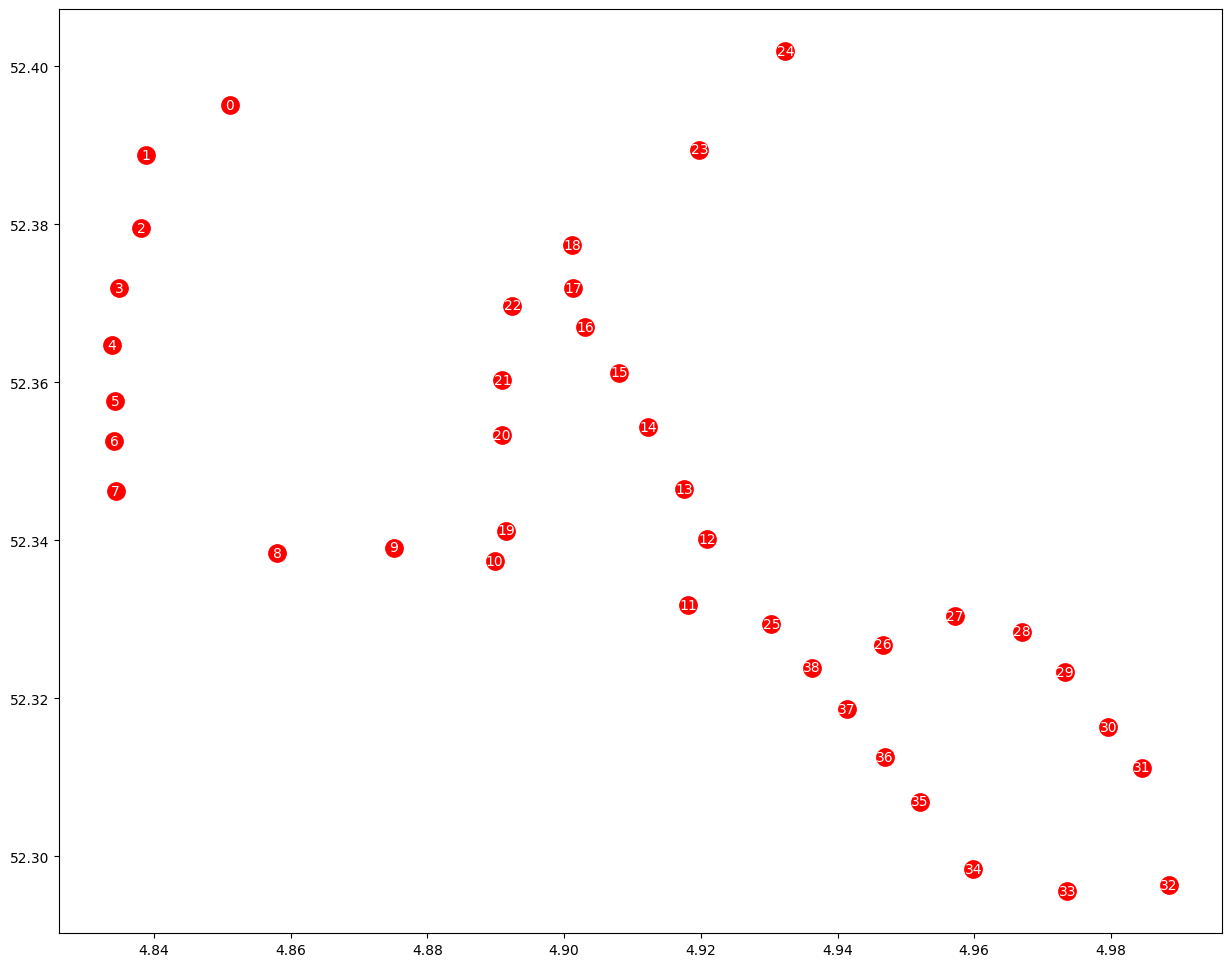

In [17]:
# Create a figure with a larger size
plt.figure(figsize=(15, 12))  # Adjust the width and height as desired

# Your existing code for plotting nodes and edges
for i in L_graph.nodes():
    lon = L_graph.nodes()[i]['lon']
    lat = L_graph.nodes()[i]['lat']
    
    # Plot the node as a red dot
    plt.plot(lon, lat, '.', color='red', markersize=25)
    
    # Plot the node number inside the node
    plt.text(lon, lat, str(i), color='white', ha='center', va='center')

# Show the figure
plt.show()

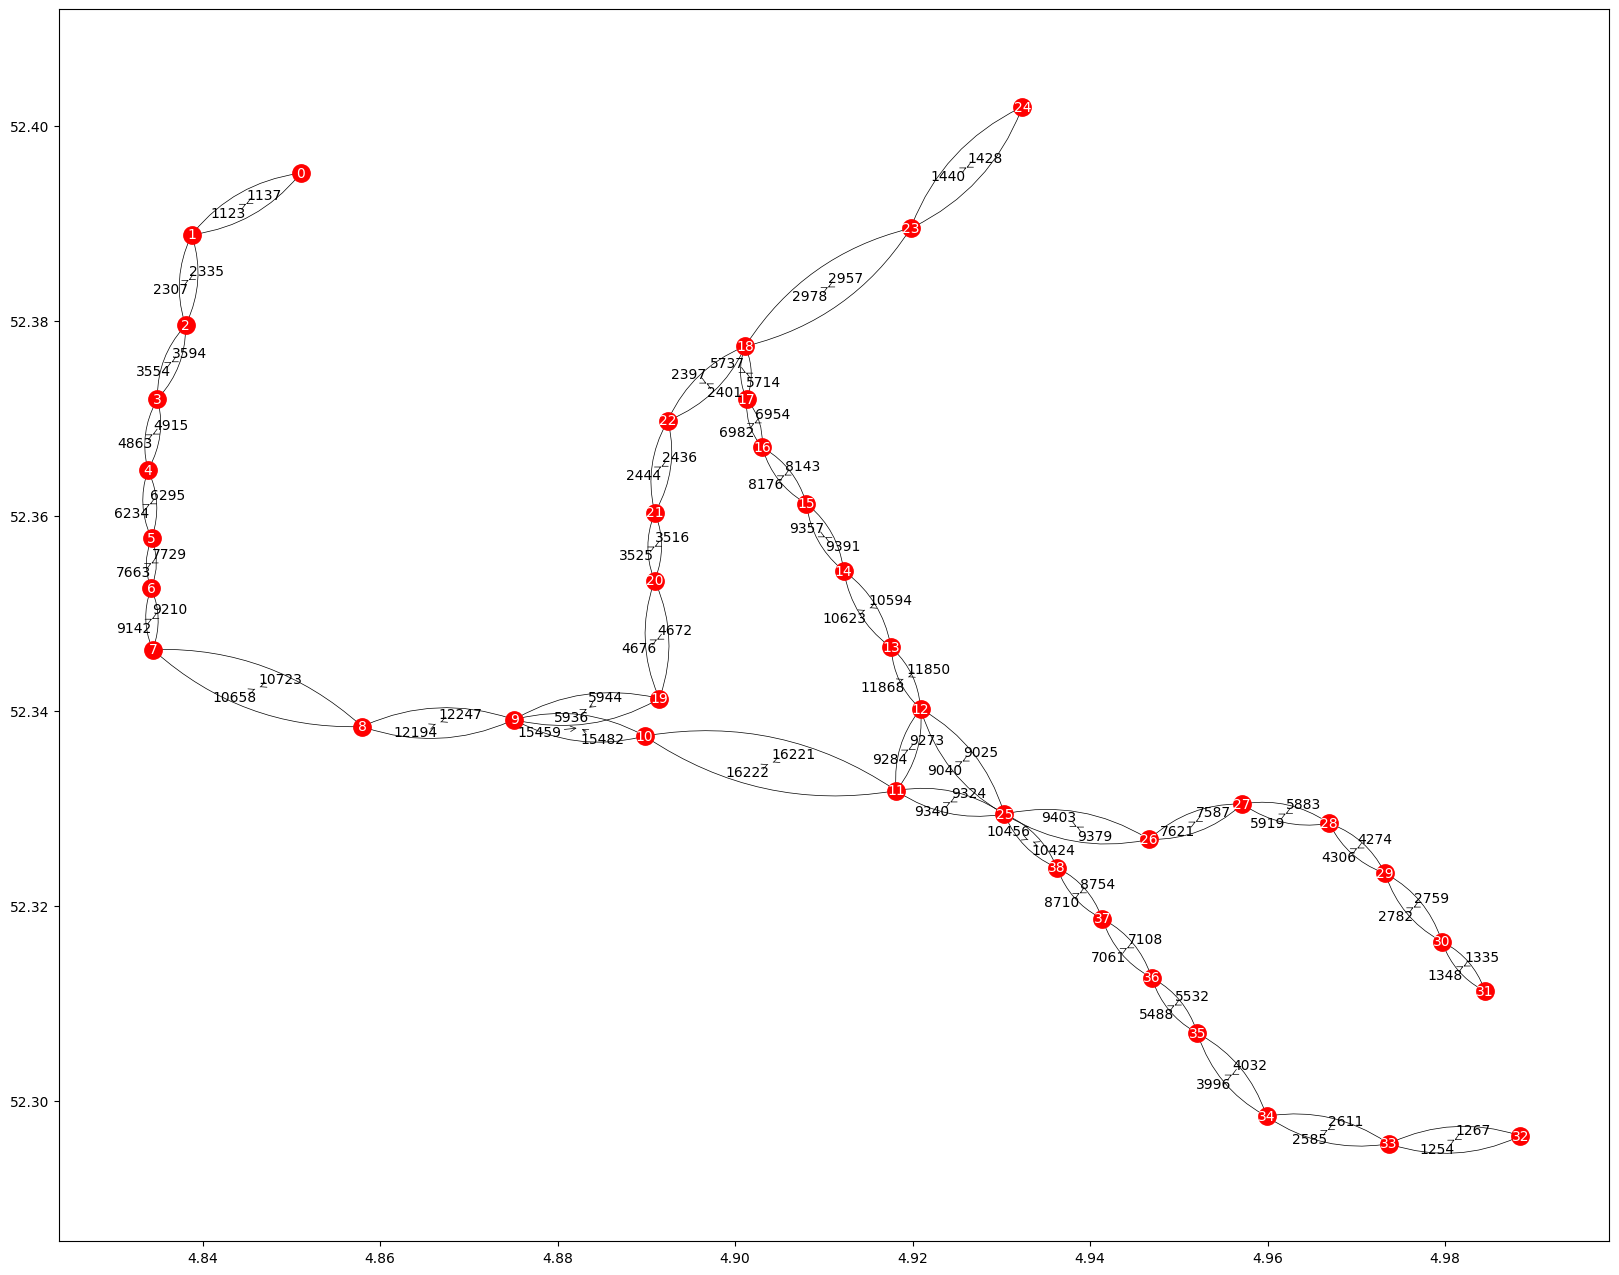

In [18]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from adjustText import adjust_text

# Create a figure with a larger size
plt.figure(figsize=(20, 16))  # Adjust the width and height as desired

# Your existing code for plotting nodes and edges
for i in L_graph.nodes():
    lon = L_graph.nodes()[i]['lon']
    lat = L_graph.nodes()[i]['lat']
    
    # Plot the node as a red dot
    plt.plot(lon, lat, '.', color='red', markersize=25)
    
    # Plot the node number inside the node as integers
    plt.text(lon, lat, str(int(i)), color='white', ha='center', va='center')  # Cast as integer

# Plot the arrows based on the edge_lists dictionary
arrows = []
texts = []
for edge, weight in edge_lists.items():
    start_node = edge[0]
    end_node = edge[1]
    
    start_lon = L_graph.nodes()[start_node]['lon']
    start_lat = L_graph.nodes()[start_node]['lat']
    end_lon = L_graph.nodes()[end_node]['lon']
    end_lat = L_graph.nodes()[end_node]['lat']
    
    dx = end_lon - start_lon
    dy = end_lat - start_lat
    
    # Calculate the arrow head position
    arrow_pos = (end_lon - dx/20, end_lat - dy/20)
    text_pos = (start_lon + dx/2, start_lat + dy/2)  # Initial position for the text annotation
    
    # Create the arrow patch with adjusted arrow thickness
    arrow = patches.FancyArrowPatch((start_lon, start_lat), (end_lon, end_lat),
                                    connectionstyle="arc3,rad=0.2", arrowstyle='->',
                                    linewidth=0.5, color='black')  # Adjust the linewidth parameter as desired
    
    # Add the arrow patch to the plot
    plt.gca().add_patch(arrow)
    
    # Annotate the arrow with the weight as integers
    text_obj = plt.text(*text_pos, str(int(weight)), color='black', ha='center', va='center')  # Cast as integer
    
    arrows.append(arrow)
    texts.append(text_obj)

# Adjust x and y limits to provide more room for the nodes and arrows
x_coords = [L_graph.nodes()[i]['lon'] for i in L_graph.nodes()]
y_coords = [L_graph.nodes()[i]['lat'] for i in L_graph.nodes()]
x_min = min(x_coords) - 0.01
x_max = max(x_coords) + 0.01
y_min = min(y_coords) - 0.01
y_max = max(y_coords) + 0.01
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)

# Adjust the positions of texts to avoid overlaps
adjust_text(texts, arrowprops=dict(arrowstyle='->', color='black', linewidth=0.5))

# Show the figure
plt.show()

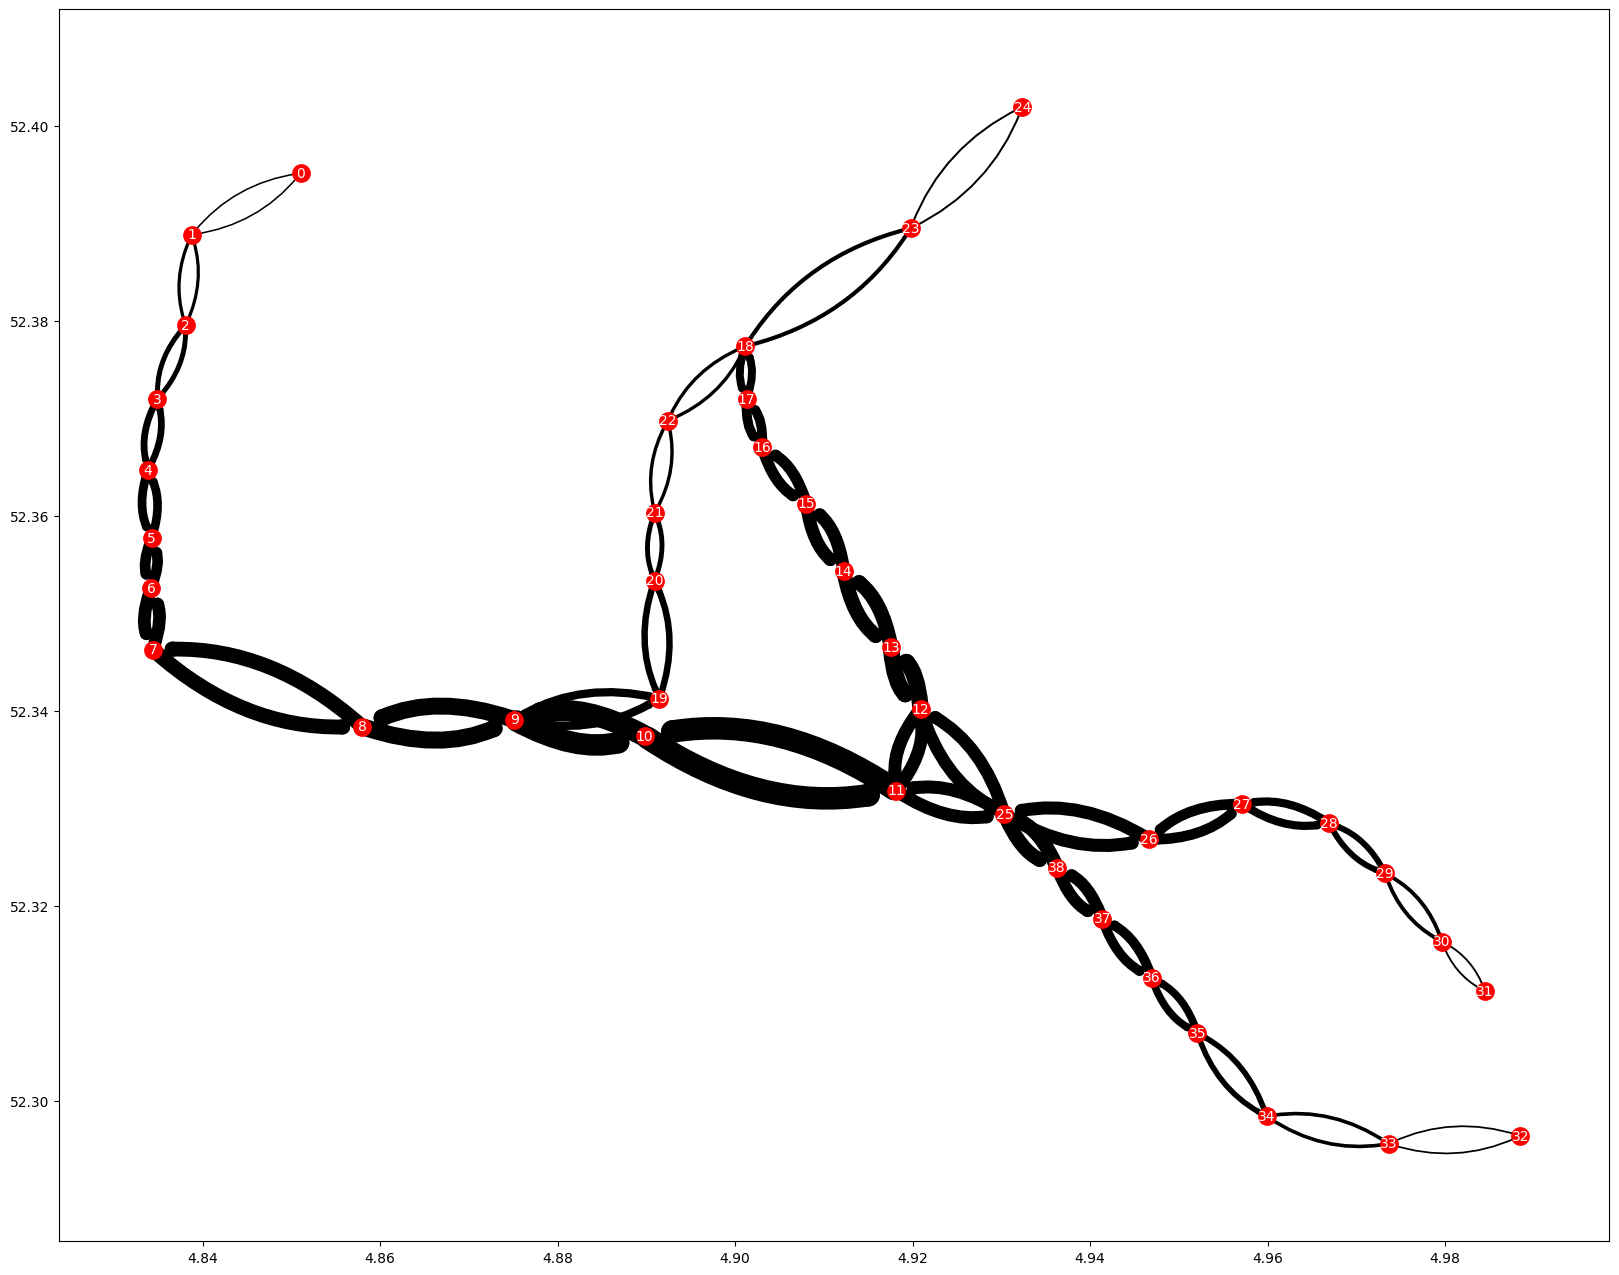

In [19]:
# Create a figure with a larger size
plt.figure(figsize=(20, 16))  # Adjust the width and height as desired

# Your existing code for plotting nodes and edges
for i in L_graph.nodes():
    lon = L_graph.nodes()[i]['lon']
    lat = L_graph.nodes()[i]['lat']

    # Plot the node as a red dot
    plt.plot(lon, lat, '.', color='red', markersize=25)

    # Plot the node number inside the node as integers
    plt.text(lon, lat, str(int(i)), color='white', ha='center', va='center')  # Cast as integer

# Plot the arrows based on the edge_lists dictionary
arrows = []
texts = []
for edge, weight in edge_lists.items():
    start_node = edge[0]
    end_node = edge[1]

    start_lon = L_graph.nodes()[start_node]['lon']
    start_lat = L_graph.nodes()[start_node]['lat']
    end_lon = L_graph.nodes()[end_node]['lon']
    end_lat = L_graph.nodes()[end_node]['lat']

    dx = end_lon - start_lon
    dy = end_lat - start_lat

    # Calculate the arrow head position
    arrow_pos = (end_lon - dx/20, end_lat - dy/20)
    text_pos = (start_lon + dx/2, start_lat + dy/2)  # Initial position for the text annotation

    # Define scaling parameter to reduce arrow thickness for readability
    scaling = 1000
    # Create the arrow patch with adjusted arrow thickness based on the weight
    arrow = patches.FancyArrowPatch((start_lon, start_lat), (end_lon, end_lat),
                                    connectionstyle="arc3,rad=0.2", arrowstyle='->',
                                    linewidth=weight/scaling, color='black')  # Adjust the linewidth as per the weight

    # Add the arrow patch to the plot
    plt.gca().add_patch(arrow)

    # Annotate the arrow with the weight as integers
    #text_obj = plt.text(*text_pos, str(int(weight)), color='black', ha='center', va='center')  # Cast as integer

    arrows.append(arrow)
    #texts.append(text_obj)

# Adjust x and y limits to provide more room for the nodes and arrows
x_coords = [L_graph.nodes()[i]['lon'] for i in L_graph.nodes()]
y_coords = [L_graph.nodes()[i]['lat'] for i in L_graph.nodes()]
x_min = min(x_coords) - 0.01
x_max = max(x_coords) + 0.01
y_min = min(y_coords) - 0.01
y_max = max(y_coords) + 0.01
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)

# Adjust the positions of texts to avoid overlaps
#adjust_text(texts, arrowprops=dict(arrowstyle='->', color='black', linewidth=0.5))

# Show the figure
plt.show()


## Undirectional

In [20]:
edge_lists_undirectional = {}

for key, value in edge_lists.items():
    reverse_key = (key[1], key[0])
    
    if key[0] < key[1]:
        if reverse_key in edge_lists_undirectional:
            edge_lists_undirectional[reverse_key] += value
        else:
            edge_lists_undirectional[key] = value
    elif key[0] > key[1]:
        if reverse_key in edge_lists_undirectional:
            edge_lists_undirectional[reverse_key] += value
        else:
            edge_lists_undirectional[reverse_key] = value

In [21]:
edge_lists_undirectional

{(0, 1): 2260.7636386548916,
 (1, 2): 4642.802431896904,
 (2, 3): 7148.7536432541965,
 (3, 4): 9778.871746538467,
 (4, 5): 12529.839886203605,
 (5, 6): 15393.130887583437,
 (6, 7): 18352.778815220296,
 (7, 8): 21382.404307959077,
 (8, 9): 24441.34351333847,
 (9, 10): 30942.007689249167,
 (9, 19): 11881.040282074075,
 (10, 11): 32443.80659244446,
 (11, 12): 18558.553852123085,
 (11, 25): 18665.091281872767,
 (12, 13): 23718.794732070008,
 (12, 25): 18066.15707265874,
 (13, 14): 21218.169105184978,
 (14, 15): 18749.880224982597,
 (15, 16): 16320.75276760336,
 (16, 17): 13936.819202713938,
 (17, 18): 11452.799827144438,
 (18, 23): 5935.499076225929,
 (18, 22): 4799.251527566068,
 (19, 20): 9348.475746334214,
 (20, 21): 7041.909044431197,
 (21, 22): 4881.481307493345,
 (23, 24): 2868.404421797133,
 (25, 26): 18783.019180798772,
 (25, 38): 20880.954652940753,
 (26, 27): 15208.77960449304,
 (27, 28): 11803.204353715613,
 (28, 29): 8580.054839326254,
 (29, 30): 5541.800273590834,
 (30, 31): 2

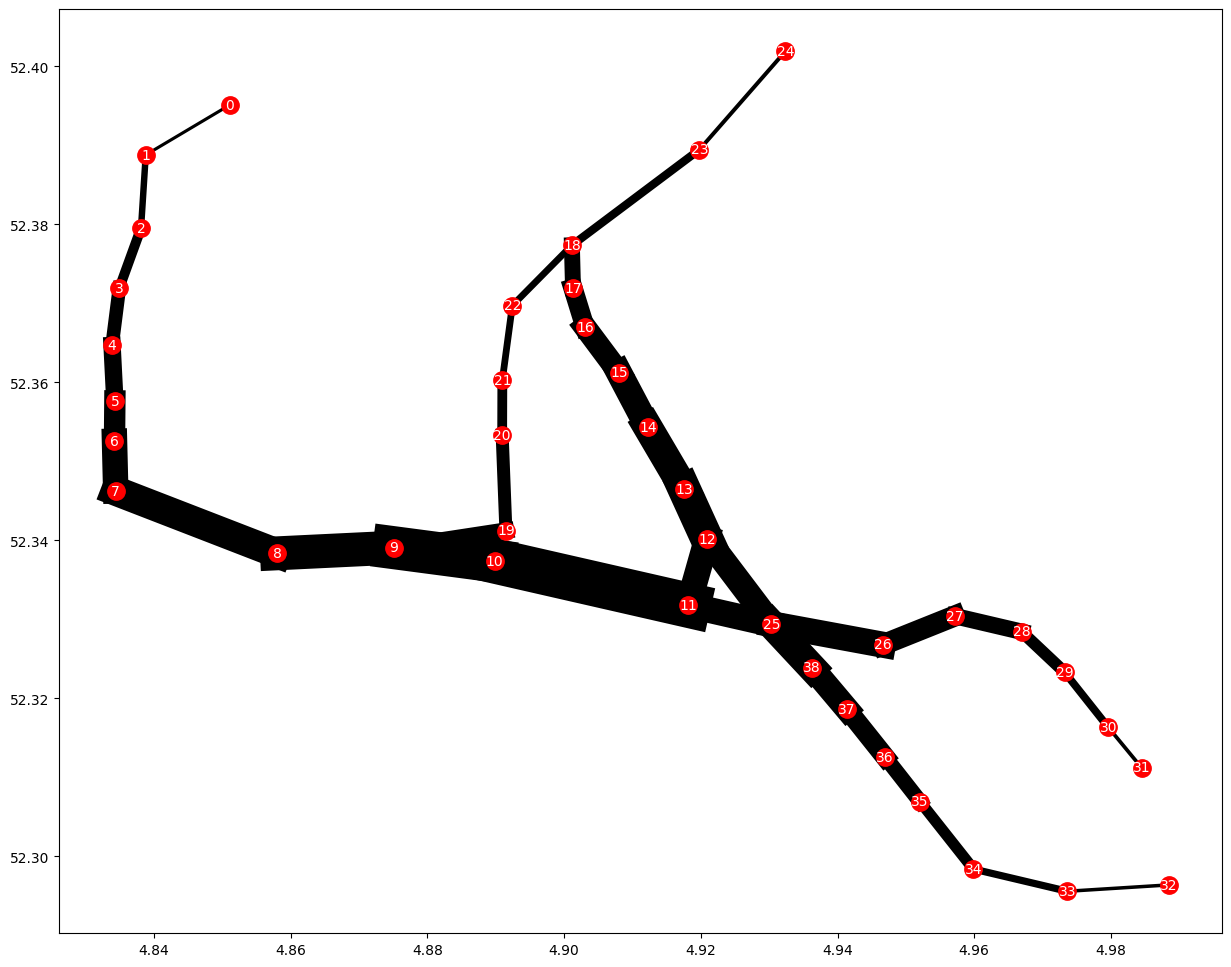

In [22]:
# Create a figure with a larger size
plt.figure(figsize=(15, 12))  # Adjust the width and height as desired

# Plot edges and annotate with values first edges so nodes are printed ontop
for key, value in edge_lists_undirectional.items():
    node1 = key[0]
    node2 = key[1]
    lon1 = L_graph.nodes()[node1]['lon']
    lat1 = L_graph.nodes()[node1]['lat']
    lon2 = L_graph.nodes()[node2]['lon']
    lat2 = L_graph.nodes()[node2]['lat']

    # Plot the line between the nodes
    plt.plot([lon1, lon2], [lat1, lat2], '-', color='black', linewidth=value/scaling)

    # Annotate the line with the rounded down integer value
    #text = str(int(value))
    #bbox_props = dict(boxstyle='round', facecolor='white', edgecolor='black', alpha=0.8)
    #plt.text((lon1 + lon2) / 2, (lat1 + lat2) / 2, text, color='black', ha='center', va='center', bbox=bbox_props)

# Your existing code for plotting nodes
for i in L_graph.nodes():
    lon = L_graph.nodes()[i]['lon']
    lat = L_graph.nodes()[i]['lat']
    
    # Plot the node as a red dot
    plt.plot(lon, lat, '.', color='red', markersize=25)
    
    # Plot the node number inside the node
    plt.text(lon, lat, str(i), color='white', ha='center', va='center')



# Show the figure
plt.show()

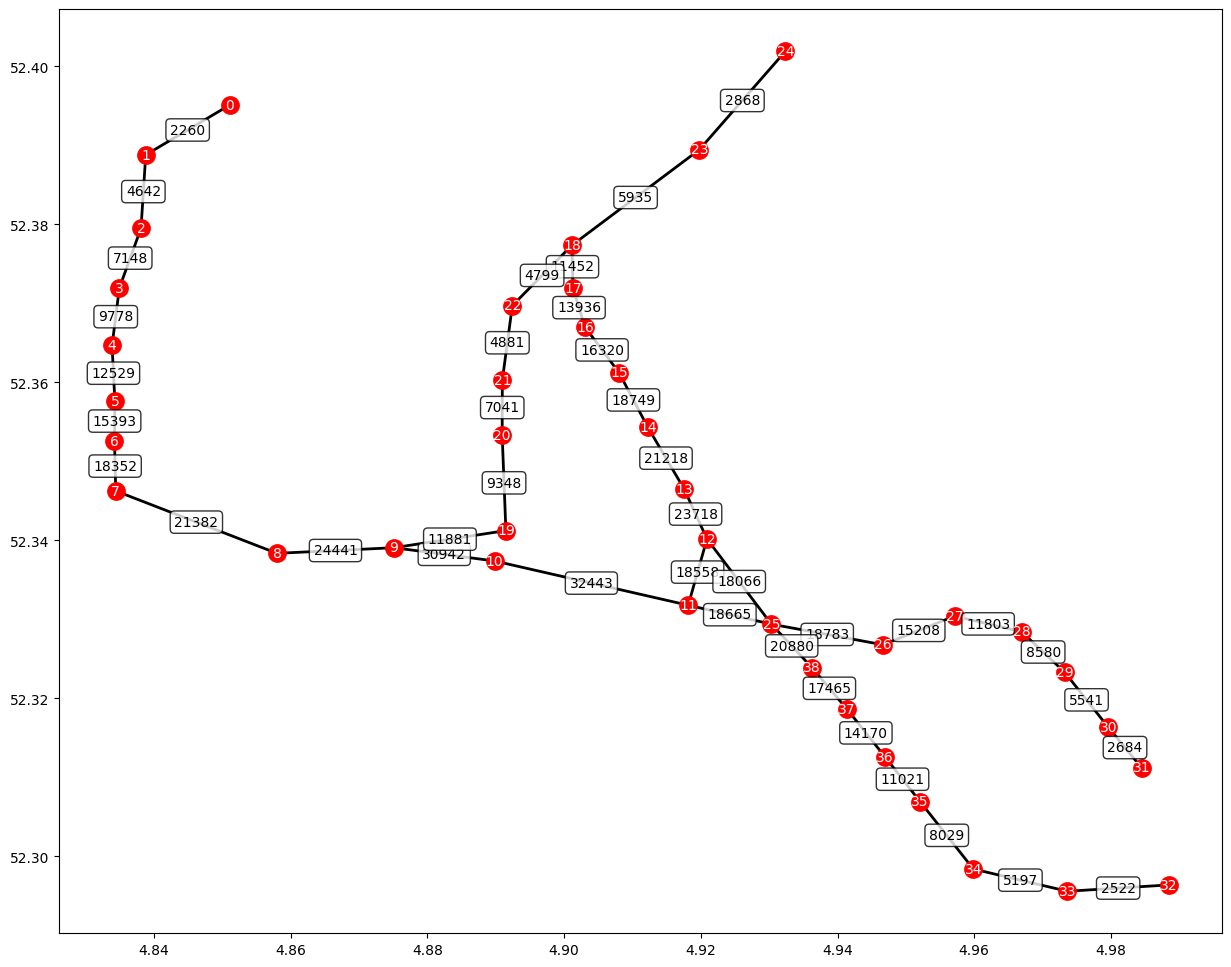

In [23]:


# Create a figure with a larger size
plt.figure(figsize=(15, 12))  # Adjust the width and height as desired

# Plot edges and annotate with values
for key, value in edge_lists_undirectional.items():
    node1 = key[0]
    node2 = key[1]
    lon1 = L_graph.nodes()[node1]['lon']
    lat1 = L_graph.nodes()[node1]['lat']
    lon2 = L_graph.nodes()[node2]['lon']
    lat2 = L_graph.nodes()[node2]['lat']

    # Plot the line between the nodes
    plt.plot([lon1, lon2], [lat1, lat2], '-', color='black', linewidth=2)

    # Annotate the line with the rounded down integer value
    text = str(int(value))
    bbox_props = dict(boxstyle='round', facecolor='white', edgecolor='black', alpha=0.8)
    plt.text((lon1 + lon2) / 2, (lat1 + lat2) / 2, text, color='black', ha='center', va='center', bbox=bbox_props)

# Your existing code for plotting nodes
for i in L_graph.nodes():
    lon = L_graph.nodes()[i]['lon']
    lat = L_graph.nodes()[i]['lat']

    # Plot the node as a red dot
    plt.plot(lon, lat, '.', color='red', markersize=25)

    # Plot the node number inside the node
    plt.text(lon, lat, str(i), color='white', ha='center', va='center')



# Show the figure
plt.show()

## Step 3: Optimal vehicle capacity
Use undirected graph since directionality does not seem to add extra information
empirical cumulative distribution function (ECDF)

In [24]:
# Retrieve unique attribute names
unique_attributes = set()
for _, _, data in L_graph.edges.data():
    unique_attributes.update(data.keys())

# Print the unique attribute names
print(list(unique_attributes))


['n_vehicles', 'direction_id', 'd', 'duration_avg', 'shape_id', 'headsign', 'route_I_counts']


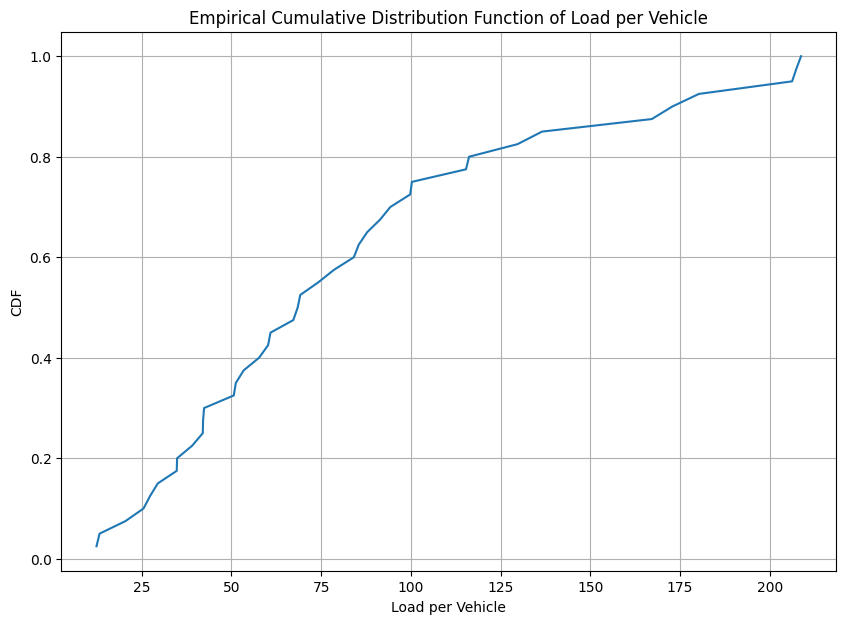

Optimal vehicle capacity (90th percentile of load per vehicle): 174


In [25]:
# Step 1: Compute load per vehicle on each link
# The load per vehicle can be computed by dividing the link load (passenger volume) by the number of vehicles operating on that link.
# I'm assuming edge_lists_undirectional represents the passenger volume for each link.

load_per_vehicle = {}

for edge, volume in edge_lists_undirectional.items():
    n_vehicles = L_graph.edges[edge]['n_vehicles']  # Retrieve the number of vehicles on this edge
    load_per_vehicle[edge] = volume / n_vehicles if n_vehicles > 0 else 0  # Compute load per vehicle, default to 0 if n_vehicles is 0

# Step 2: Analyze the ECDF of the load per vehicle for each link

# Generate a sorted list of load per vehicle
sorted_load = sorted(load_per_vehicle.values())

# Generate empirical cumulative distribution values
cdf = np.arange(1, len(sorted_load)+1) / len(sorted_load)

# Plot the ECDF
plt.figure(figsize=(10, 7))
plt.plot(sorted_load, cdf)
plt.xlabel('Load per Vehicle')
plt.ylabel('CDF')
plt.title('Empirical Cumulative Distribution Function of Load per Vehicle')
plt.grid(True)
plt.show()

# Analyze the ECDF to determine the optimal vehicle capacity
# Assuming a balance between operating costs and level-of-service, an initial heuristic could be to set the capacity at a value
# that ensures around 95% of vehicles are not overcrowded. We will find the 90th percentile of the load per vehicle as the vehicle capacity.
vehicle_capacity = np.percentile(sorted_load, 90)
vehicle_capacity = int(np.ceil(vehicle_capacity))  # Round up to the nearest integer
print(f'Optimal vehicle capacity (90th percentile of load per vehicle): {vehicle_capacity}')

In [26]:
#L_graph.edges(data=True)

## Step 4: Analyise network performance

In [27]:
# Step 1: Compute the saturation level for each link

for edge, volume in edge_lists_undirectional.items():
    L_graph.edges[edge]['saturation'] = volume / vehicle_capacity  # Add the saturation level as a new attribute to the edge

# Plot the graph with edges colored by saturation level
plot_graph(L_graph, edge_color_by="saturation")


In [28]:
# Step 2: Compute the performance metrics for the network
# Transfer penalties in minutes. Arbitrary size of at least one element, with the minutes to add
# for the first, second, third... transfers.

alpha = 2       # 2 times multiplier for waiting time
betas = [5,15]  # 5 minutes for the first transfer, 15 minutes for any transfer after that.
m = 3           # Number of shortest paths to retrieve

gtc_results = get_all_GTC(L_graph, P, m, alpha, betas)

0/39
10/39
20/39
30/39
All GTC computed!


In [29]:
print(gtc_results)

{0: {1: [{'path': [0, 1], 'GTC': 8, 'in_vehicle': 2, 'waiting_time': 3, 'n_transfers': 0, 'traveled_distance': 1041}], 2: [{'path': [0, 1, 2], 'GTC': 9, 'in_vehicle': 3, 'waiting_time': 3, 'n_transfers': 0, 'traveled_distance': 2079}], 3: [{'path': [0, 1, 2, 3], 'GTC': 11, 'in_vehicle': 5, 'waiting_time': 3, 'n_transfers': 0, 'traveled_distance': 2944}], 4: [{'path': [0, 1, 2, 3, 4], 'GTC': 12, 'in_vehicle': 6, 'waiting_time': 3, 'n_transfers': 0, 'traveled_distance': 3773}], 5: [{'path': [0, 1, 2, 3, 4, 5], 'GTC': 13, 'in_vehicle': 7, 'waiting_time': 3, 'n_transfers': 0, 'traveled_distance': 4539}], 6: [{'path': [0, 1, 2, 3, 4, 5, 6], 'GTC': 14, 'in_vehicle': 8, 'waiting_time': 3, 'n_transfers': 0, 'traveled_distance': 5105}], 7: [{'path': [0, 1, 2, 3, 4, 5, 6, 7], 'GTC': 15, 'in_vehicle': 9, 'waiting_time': 3, 'n_transfers': 0, 'traveled_distance': 5805}], 8: [{'path': [0, 1, 2, 3, 4, 5, 6, 7, 8], 'GTC': 17, 'in_vehicle': 11, 'waiting_time': 3, 'n_transfers': 0, 'traveled_distance': 

In [30]:
# Step 3: Analyze the performance metrics
def analyze_performance(gtc_results):
    # Initialize variables
    total_travel_time = 0
    total_transfers = 0
    total_waiting_time = 0
    total_paths = 0
    max_travel_time = float('-inf')
    min_travel_time = float('inf')

    # Loop over all origin-destination pairs
    for origin, destinations in gtc_results.items():
        for destination, paths in destinations.items():
            for path in paths:
                travel_time = path['in_vehicle']
                waiting_time = path['waiting_time']
                n_transfers = path['n_transfers']

                # Update totals
                total_travel_time += travel_time
                total_transfers += n_transfers
                total_waiting_time += waiting_time
                total_paths += 1

                # Update min/max travel times
                max_travel_time = max(max_travel_time, travel_time)
                min_travel_time = min(min_travel_time, travel_time)

    # Calculate averages
    avg_travel_time = np.round(total_travel_time / total_paths)
    avg_transfers = np.round(total_transfers / total_paths)
    avg_waiting_time = np.round(total_waiting_time / total_paths)

    # Return the results as a dictionary
    results = {
        'average_travel_time': avg_travel_time,
        'minimum_travel_time': min_travel_time,
        'maximum_travel_time': max_travel_time,
        'average_number_of_transfers': avg_transfers,
        'average_waiting_time': avg_waiting_time
    }

    return results


In [31]:
def analyze_performance_OD(gtc_results, passenger_volume_dict):
    # This function only works for undirected graphs

    # Initialize DataFrame
    result_df = pd.DataFrame(columns=["path_volume", "travel_time", "n_transfers", "waiting_time"])

    # Loop over all origin-destination pairs
    for origin, destinations in gtc_results.items():
        for destination, paths in destinations.items():

            for path in paths:
                travel_time = path['in_vehicle']
                waiting_time = path['waiting_time']
                n_transfers = path['n_transfers']

                # Retrieve volume from passenger_volume_dict for each edge in the current path
                path_volume = 0
                for i in range(len(path['path']) - 1):
                    edge = (path['path'][i], path['path'][i + 1])
                    if edge in passenger_volume_dict:
                        path_volume += passenger_volume_dict[edge]
                    else:  # Check the edge in reverse direction
                        path_volume += passenger_volume_dict[(edge[1], edge[0])]       # undirected!

                # Append the results as a new row in the DataFrame
                new_row = pd.DataFrame({"path_volume": [path_volume],
                                        "travel_time": [travel_time],
                                        "n_transfers": [n_transfers],
                                        "waiting_time": [waiting_time]})
                result_df = pd.concat([result_df, new_row], ignore_index=True)
    """
    # Calculate the minimum, maximum and mean for each column
    min_row = pd.DataFrame(result_df.min()).T
    min_row.index = ["Minimum"]
    max_row = pd.DataFrame(result_df.max()).T
    max_row.index = ["Maximum"]
    mean_row = pd.DataFrame(result_df.mean()).T
    mean_row.index = ["Mean"]

    # Append the min, max, mean rows at the end
    result_df = pd.concat([result_df, min_row, max_row, mean_row], ignore_index=False)
    """
    return result_df

In [32]:
# Analyze the performance metrics
performance_metrics = analyze_performance(gtc_results)
print(performance_metrics)

{'average_travel_time': 15.0, 'minimum_travel_time': 1, 'maximum_travel_time': 37, 'average_number_of_transfers': 2.0, 'average_waiting_time': 13.0}


## Step 5: Perform robustness analysis


In [59]:
def OriginDestination_matrix(OD, gtc, alpha_impedance, beta_impedance, removed_nodes):
    # This function takes an (empty) OD matrix, a GTC matrix and the impedance function variables
    # It first calculates the impedence function (f_ij) and assigns it to the OD matrix
    # Then it calculates the OD matrix (x_ij) and assigns it to the OD matrix

    # Initialize variables
    n = len(OD)                             # Get the number of stations adjusted for node removal
    f = np.zeros((n, n))                    # Initialize the impedance function matrix
    x = np.zeros((n, n))                    # Initialize the OD matrix
    q = a = Origin_matrix(L_graph, Q, removed_nodes)       # Calculate the total production for each station (origin)

    # Double loop, calculate f_ij and x_ij for each OD pair
    for i in range(n):
        for j in range(n):
            if i != j:                      # Make sure that diagonal is empty (cannot travel to the same station)
                # Get the node ids for current OD pair
                origin_node = OD.index[i]
                destination_node = OD.columns[j]

                # Check if origin and destination nodes exist in gtc
                if origin_node in gtc and destination_node in gtc[origin_node]:
                    # Get the GTC values for OD pair i,j
                    my_list = gtc[origin_node][destination_node]
                    f[i][j] = alpha_impedance * np.exp(-beta_impedance * my_list[0]['GTC'])
                    x[i][j] = (a[j] * f[i][j] * q[i]) / np.sum(np.delete(a * f[i][j], i))
                    OD.at[origin_node, destination_node] = x[i][j]        # Assign x_ij to the respective spot in the OD matrix
    OD.fillna(0, inplace=True)              # Replace NaN values with 0
    return OD

In [60]:
removed_nodes = []
origin_matrix_test = Origin_matrix(L_graph, Q, removed_nodes)
print(f"Origin matrix: {len(origin_matrix_test)}, {origin_matrix_test}")

Origin matrix: 39, [1123.4181853  1221.91693614 1332.42621977 1456.63544365 1596.43636858
 1753.90798317 1931.26946462 2130.78077294 2354.56140207 2604.28761138
 2644.35357463 2685.67159923 2591.20073896 2343.85885024 2139.62218694
 1968.12575211 1822.08108499 1802.96834634 1784.25241195 2354.56140207
 2148.53727939 1975.6664638  1828.54236543 1591.50909584 1428.39043505
 2657.98426316 2333.25315408 2062.59578821 1835.04963364 1642.19409889
 1477.50414628 1335.87810117 1254.62030913 1378.74050014 1521.08833939
 1685.12727795 1875.08708019 2096.13393111 2354.56140207]


In [61]:
# Initialisation
alpha_impedance = 5     # impedance function variable
beta_impedance = 0.5    # impedance function variable
alpha = 2               # 2 times multiplier for waiting time
betas = [5,15]          # 5 minutes for the first transfer, 15 minutes for any transfer after that.
OD_test = pd.DataFrame(np.nan, index=node_list, columns=node_list)
gtc_test = get_all_GTC(L_graph, P, m, alpha, betas)
node_list = list(L_graph.nodes)
OD_test_filled = OriginDestination_matrix(OD_test, gtc_test, alpha_impedance, beta_impedance,  removed_nodes)

0/39
10/39
20/39
30/39
All GTC computed!


In [62]:
OD_test_filled.head(5)

10         11         12         13         14         15   
10   0.000000  18.804078  20.504706  22.416161  24.567558  26.990888  \
11  18.829485   0.000000  22.332644  24.414501  26.757689  29.397052   
12  20.563581  22.366549   0.000000  26.662948  29.221930  32.104366   
13  22.518950  24.493360  26.708522   0.000000  32.000613  35.157136   
14  24.727783  26.895859  29.328301  32.062295   0.000000  38.605621   

           16         17         18         19         20         21   
10  29.720304  32.790583  36.234343  40.077379  40.693954  41.329797  \
11  32.369788  35.713774  39.464536  43.650169  44.321710  45.014236   
12  35.350875  39.002824  43.099011  47.670119  48.403505  49.159810   
13  38.712352  42.711562  47.197251  52.203020  53.006143  53.834364   
14  42.509560  46.901043  51.826724  57.323497  58.205397  59.114857   

           22         23         24  
10  39.875985  36.069641  32.926644  
11  43.430821  39.285152  35.861964  
12  47.430570  42.903107  39.164662  
13  51.940693  46.982718  42.888788  
14  57.035440  51.591148  47.095653

In [63]:
def passenger_assignment(graph, gtc, OD_matrix, beta_I, beta_W, beta_T):
    # Initialize 'people' attribute for all edges
    for u, v, data in graph.edges(data=True):
        data['people'] = 0

    # Dictionary to store edge and passenger volume tuples
    passenger_volume_dict = {}

    # Loop over all OD pairs
    for start in gtc:
        for end in gtc[start]:
            # Check if there are paths for this OD pair
            if not gtc[start][end]:
                continue

            # Initialize parameters
            utility = np.zeros(3)
            route_choice = np.zeros(3)

            # Calculate utilities for each path
            for i in range(min(3, len(gtc[start][end]))):
                utility[i] = beta_I * gtc[start][end][i]['in_vehicle'] + beta_W * gtc[start][end][i]['waiting_time'] + beta_T * gtc[start][end][i]['n_transfers']

            # Calculate probabilities of choosing a path and assign people to each path
            for i in range(min(3, len(gtc[start][end]))):
                route_choice[i] = np.exp(utility[i]) / np.sum(np.exp(utility))

                # Calculate number of people choosing this path
                people_choosing_path = route_choice[i] * OD_matrix[start][end]

                # Assign people to the edges in this path
                for k in range(len(gtc[start][end][i]['path']) - 1):
                    node1 = gtc[start][end][i]['path'][k]
                    node2 = gtc[start][end][i]['path'][k + 1]
                    graph[node1][node2]['people'] += people_choosing_path

    # Create the dictionary of edges and their passenger volumes
    for edge in graph.edges():
        u, v = edge
        passenger_volume = graph[u][v]['people']
        # Make sure the edges are undirected in the dictionary
        if (v, u) in passenger_volume_dict:
            passenger_volume_dict[(v, u)] += passenger_volume
        else:
            passenger_volume_dict[(u, v)] = passenger_volume

    return passenger_volume_dict



In [64]:
def plot_network(L_graph, edge_lists_undirectional):
    # Create a figure with a larger size
    plt.figure(figsize=(15, 12))  # Adjust the width and height as desired

    # Plot edges and annotate with values
    for key, value in edge_lists_undirectional.items():
        node1 = key[0]
        node2 = key[1]
        lon1 = L_graph.nodes()[node1]['lon']
        lat1 = L_graph.nodes()[node1]['lat']
        lon2 = L_graph.nodes()[node2]['lon']
        lat2 = L_graph.nodes()[node2]['lat']

        # Plot the line between the nodes
        plt.plot([lon1, lon2], [lat1, lat2], '-', color='black', linewidth=2)

        # Annotate the line with the rounded down integer value
        text = str(int(value))
        bbox_props = dict(boxstyle='round', facecolor='white', edgecolor='black', alpha=0.8)
        plt.text((lon1 + lon2) / 2, (lat1 + lat2) / 2, text, color='black', ha='center', va='center', bbox=bbox_props)

    # Your existing code for plotting nodes
    for i in L_graph.nodes():
        lon = L_graph.nodes()[i]['lon']
        lat = L_graph.nodes()[i]['lat']

        # Plot the node as a red dot
        plt.plot(lon, lat, '.', color='red', markersize=25)

        # Plot the node number inside the node
        plt.text(lon, lat, str(i), color='white', ha='center', va='center')

    # Show the figure
    plt.show()

In [65]:
#Original parameters
#alpha = 2
#betas = [5,15]

#Updated parameters
alpha = beta_W/beta_I                              # multiplier for waiting time
betas = [beta_T/beta_I, beta_T/beta_I]             # multiplier for each transfer



-------------------Iteration: 0 -------------------
network is connected
Using headsign field as indicator for the direction of routes
0/39
10/39
20/39
30/39
All GTC computed!


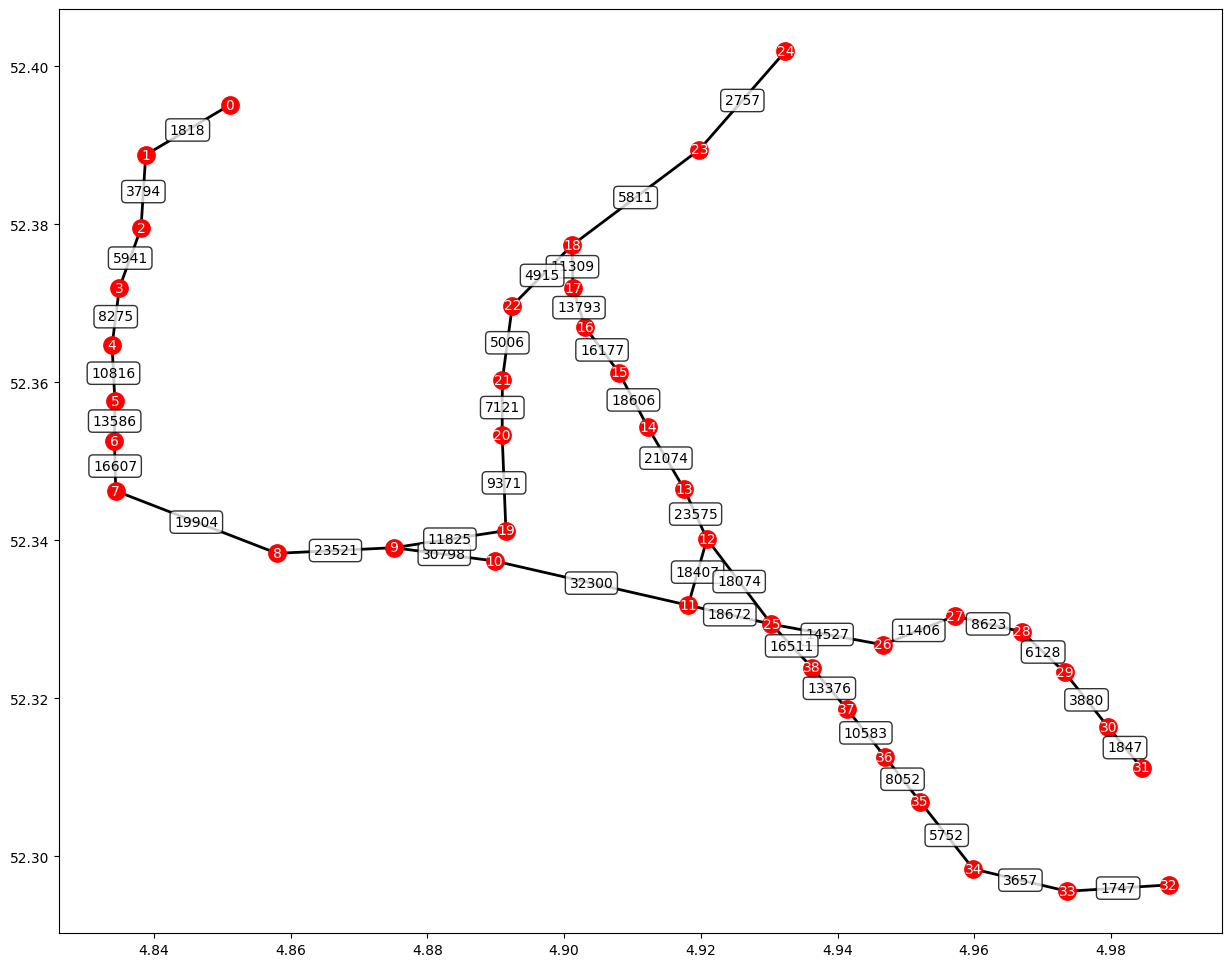


-------------------Iteration: 1 -------------------
network is not connected
Using headsign field as indicator for the direction of routes
0/25
10/25
20/25
All GTC computed!


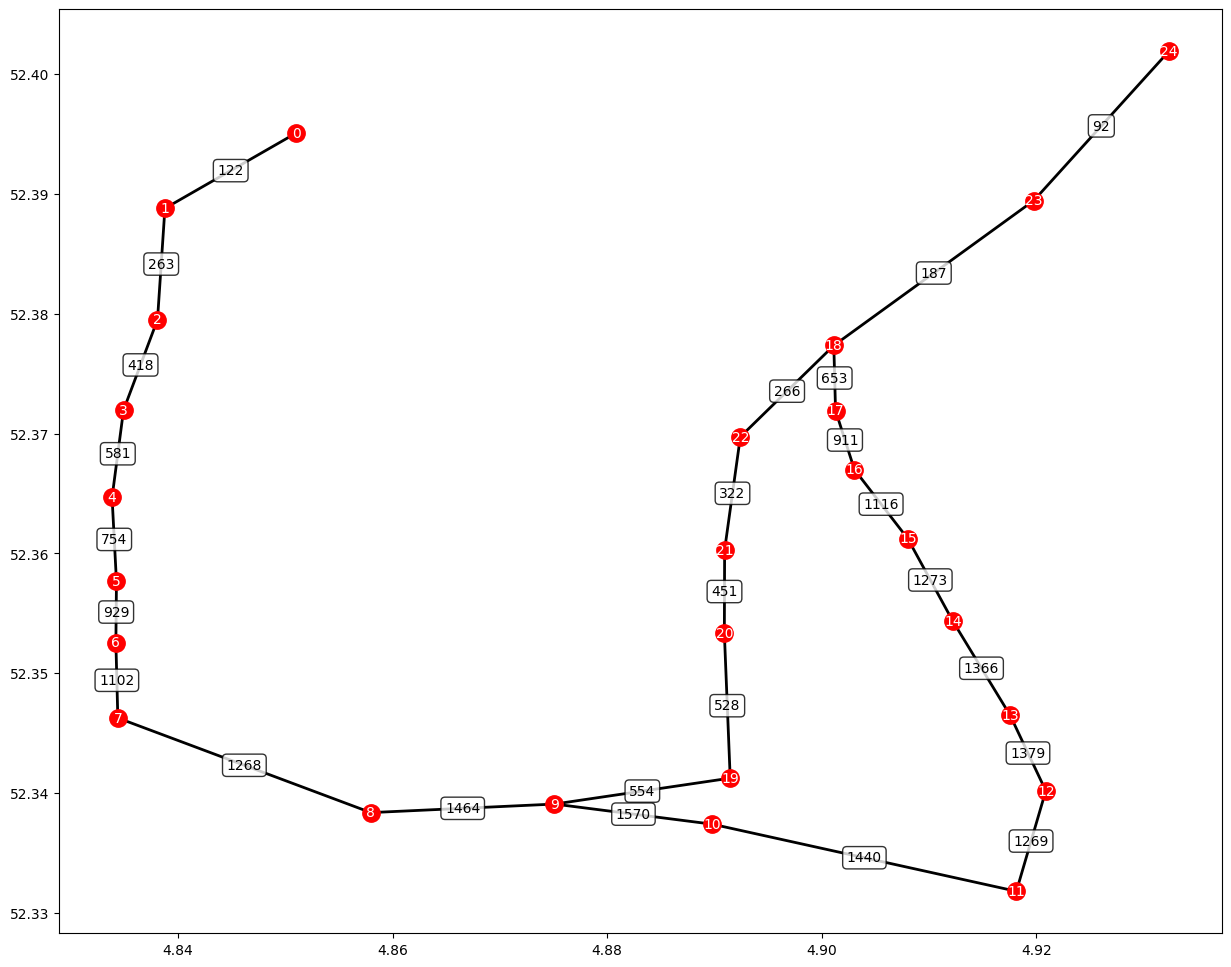


-------------------Iteration: 2 -------------------
network is not connected
Using headsign field as indicator for the direction of routes
10/15
20/15
All GTC computed!


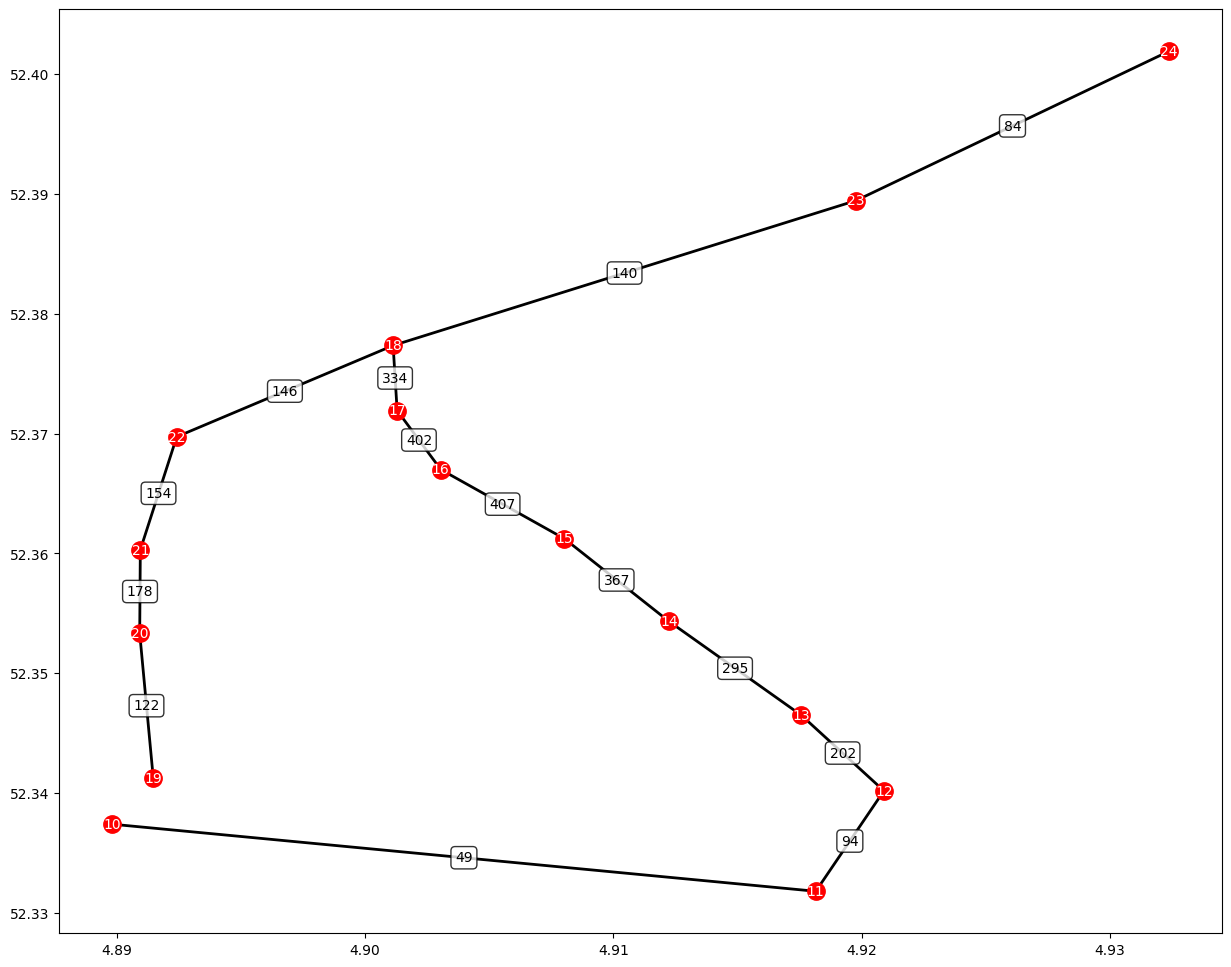


-------------------Iteration: 3 -------------------
network is not connected
Using headsign field as indicator for the direction of routes
10/8
All GTC computed!


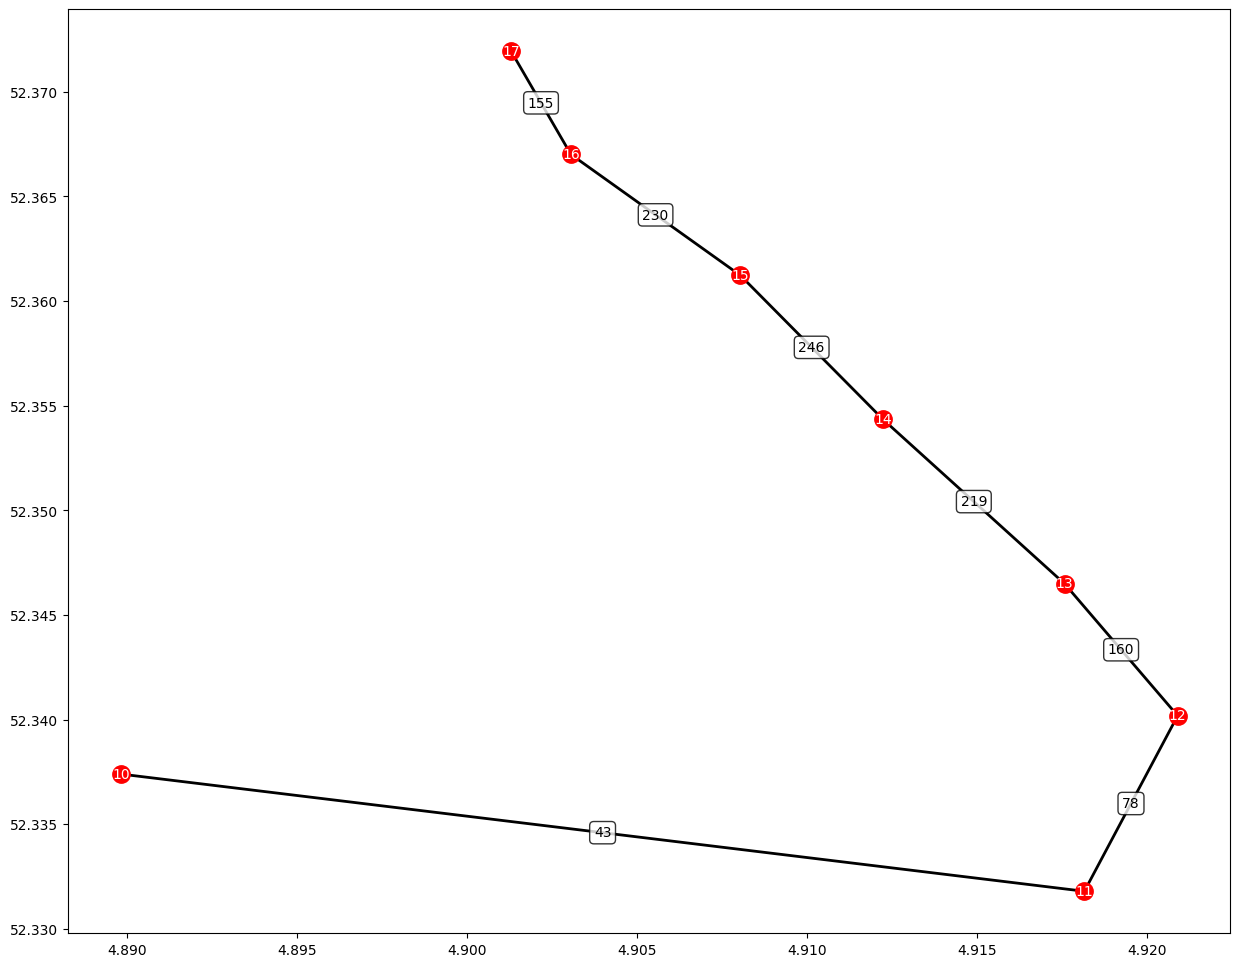


-------------------Iteration: 4 -------------------
network is not connected
Using headsign field as indicator for the direction of routes
All GTC computed!


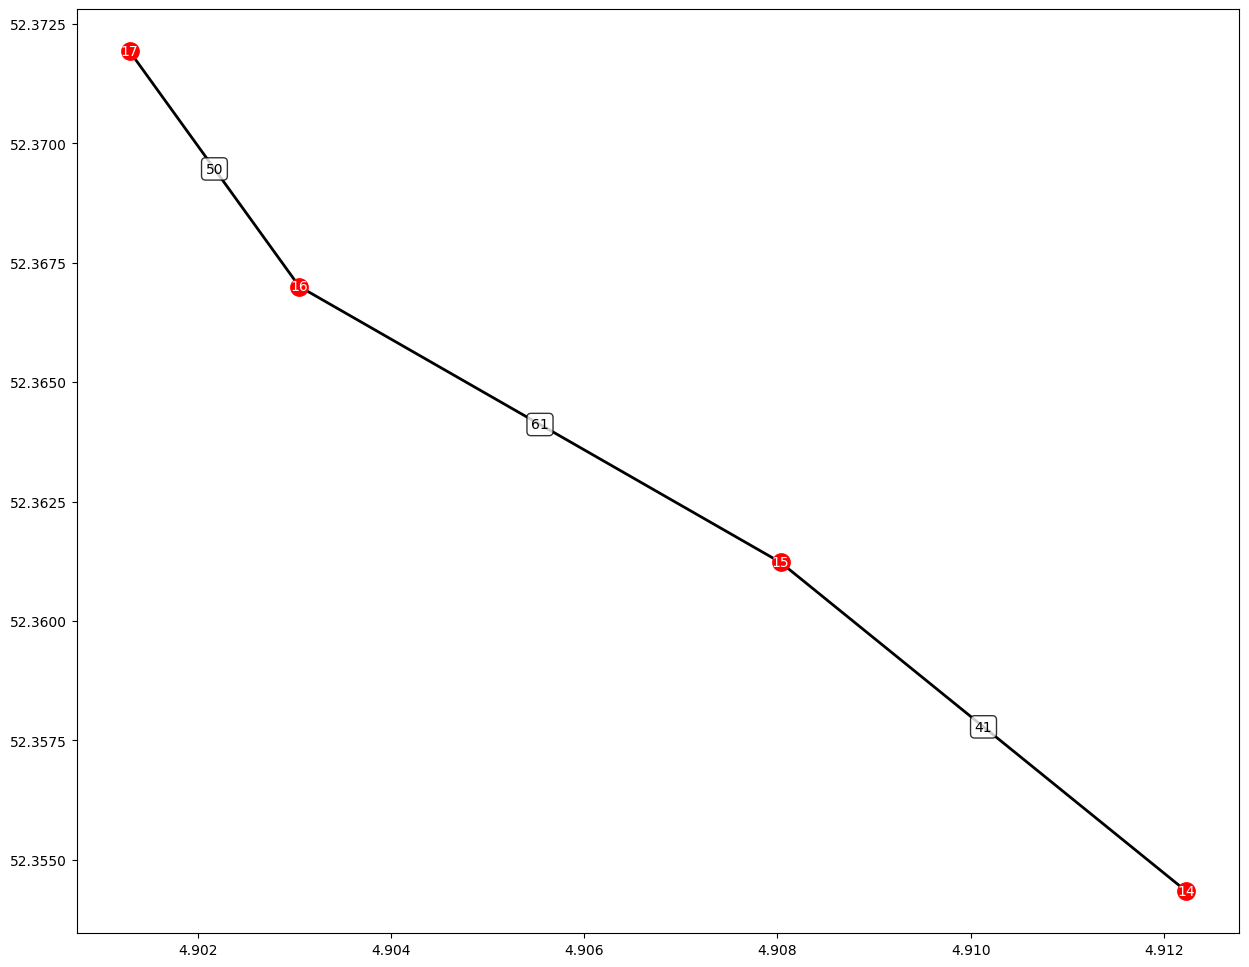

In [69]:
# Initialisation
results = []                        # Initialize the list to store results for each iteration
alpha = beta_W/beta_I                              # multiplier for waiting time
betas = [beta_T/beta_I, beta_T/beta_I]             # multiplier for each transfer
m = 3                               # Number of shortest paths to retrieve
alpha_impedance = 5                 # impedance function variable
beta_impedance = 0.5                # impedance function variable
network = L_graph.copy()            # Initialize network
node_list = list(network.nodes)     # Get list of nodes in the network
removed_nodes = []                  # Initialize list of removed nodes
performance_metrics_dict = {}       # Initialize dictionary to store performance metrics (dataframe per iteration)
passenger_volume_dict = {}          # Initialize dictionary to store passenger volumes (dataframe per iteration)
sum_OD_iteration = pd.DataFrame()   # Initialize dataframe to store total passengers (dataframe per iteration)

# Create empty dataframe to store the OD matrix
OD_matrix_iteration = pd.DataFrame(np.nan, index=node_list, columns=node_list)

#number of iterations
n_iterations = 5

# Repeat steps 5 times
for iteration in range(n_iterations):
    print(f"\n-------------------Iteration: {iteration} -------------------")
    betweenness = nx.betweenness_centrality(network)                # Calculate betweenness centrality
    max_central_node = max(betweenness, key=betweenness.get)        # Identify the most central node
    #print(f"Max central node: {max_central_node}")

    if iteration != 0:
        removed_nodes.append(max_central_node)                      # Append the removed node to the list
        #print(f"Nodes before removal: {network.nodes()}")
        network.remove_node(max_central_node)
        #print(f"Nodes after removal: {network.nodes()}")
        node_list.remove(max_central_node)                          # Remove the node from the list of nodes
        OD_matrix_iteration.drop(max_central_node, axis=0, inplace=True)    # Remove the node from the OD matrix
        OD_matrix_iteration.drop(max_central_node, axis=1, inplace=True)    # Remove the node from the OD matrix
        #print(f"Removed node {max_central_node}")                   # Print the node that was removed
    #print(f"Current nodes: {node_list}")

    # Check if network is connected
    if not nx.is_connected(network):
        print("network is not connected")
        connected_components = list(nx.connected_components(network))
        largest_component = max(connected_components, key=len)

        # Find all nodes not in the largest connected component
        removed_subgraph_nodes = [node for node in node_list if node not in largest_component]

        # Update node_list and OD_matrix_iteration to reflect these nodes being removed
        for node in removed_subgraph_nodes:
            node_list.remove(node)
            OD_matrix_iteration.drop(node, axis=0, inplace=True)
            OD_matrix_iteration.drop(node, axis=1, inplace=True)

        network = network.subgraph(largest_component).copy()
    else:
        print("network is connected")

    # Reconstruct P-space
    #print(f"Nodes before P-space: {P.nodes()}")
    P_iteration = P_space(g, network, start_hour=5, end_hour=24, mode="Subway")
    P_iteration = P_iteration.to_undirected()
    #print(f"Nodes after P-space: {P_iteration.nodes()}")

    # Compute performance metrics for the network
    gtc_iteration = get_all_GTC(network, P_iteration, m, alpha, betas)
    gtc_iteration = {key: gtc_iteration[key] for key in gtc_iteration if key not in removed_nodes}  # Remove keys corresponding to removed nodes
    #print(f"Current gtc_iteration keys: {gtc_iteration.keys()}")

    # Calculate the OD matrix for the network
    OD_matrix_iteration = OriginDestination_matrix(OD_matrix_iteration, gtc_iteration, alpha_impedance, beta_impedance, removed_nodes)
    sum_OD_matrix_iteration = pd.Series(OD_matrix_iteration.sum(axis=1).sum(axis=0), name=iteration)
    sum_OD_iteration = pd.concat([sum_OD_iteration, sum_OD_matrix_iteration], axis=1)
    # Drop rows with 0 values
    sum_OD_iteration.drop(sum_OD_iteration[sum_OD_iteration[iteration] == 0].index, inplace=True)

    # Calculate the passenger volume dictionary for the network
    passenger_volume_iteration = passenger_assignment(network, gtc_iteration, OD_matrix_iteration, beta_I, beta_W, beta_T)
    passenger_volume_dict[iteration] = passenger_volume_iteration

    # Calculate the saturation level for each edge
    for edge, volume in passenger_volume_iteration.items():
        network.edges[edge]['saturation'] = volume / vehicle_capacity  # Add the saturation level as a new attribute to the edge
    # Plot the graph with edges colored by saturation level
    plot_graph(network, edge_color_by="saturation")

    # Calculate performance metrics using the modified function
    performance_metrics_df = analyze_performance_OD(gtc_iteration, passenger_volume_iteration)

    # Add the metrics to the results list
    performance_metrics_dict[iteration] = performance_metrics_df

    # Plot the network
    plot_network(network, passenger_volume_iteration)

sum_OD_iteration = sum_OD_iteration.T

In [ ]:
OD_matrix_iteration.head()

In [ ]:
# Create a figure and a grid of subplots
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(10, 10))

# Unpack all the axes subplots
ax1, ax2, ax3, ax4 = ax.flatten()

# Set a general title
fig.suptitle('Performance Metrics', fontsize=16)

# Box plots
for iteration, df in performance_metrics_dict.items():
    ax1.boxplot(df['travel_time'], positions=[iteration], widths=0.6)
    ax2.boxplot(df['n_transfers'], positions=[iteration], widths=0.6)
    ax3.boxplot(df['waiting_time'], positions=[iteration], widths=0.6)
    ax4.boxplot(df['path_volume'], positions=[iteration], widths=0.6)

# Set xticks and xlabels for each subplot
xticks = list(range(5))  # Creates a list [0, 1, 2, 3, 4]
xlabels = [str(i) for i in xticks]

for ax in [ax1, ax2, ax3, ax4]:
    ax.set_xticks(xticks)
    ax.set_xticklabels(xlabels)

# Set titles and labels
ax1.set_title('Travel Time')
ax1.set_xlabel('# of nodes removed')
ax1.set_ylabel('Travel Time (minutes)')

ax2.set_title('Number of Transfers')
ax2.set_xlabel('# of nodes removed')
ax2.set_ylabel('Number of Transfers')

ax3.set_title('Waiting Time')
ax3.set_xlabel('# of nodes removed')
ax3.set_ylabel('Waiting Time (minutes)')

ax4.set_title('Path Volume')
ax4.set_xlabel('# of nodes removed')
ax4.set_ylabel('Path Volume')

# Improve layout
plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust the padding to leave space for the suptitle

plt.show()


In [ ]:
print(f"Total passengers: {total_passengers_dict}")